In [1]:
# Load Some Packages
import numpy as np
import imageio
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import os, glob, ntpath

In [2]:
maxIter = 5000

# Given the range of the rectangle
lenX = 250
lenY = 250

deltaX = 1
deltaY = 1
deltaT = 0.1
# Need to use CFL condition to verify the upper boundary of deltaT

In [3]:
# Given Some Coefficients in Partial(K)/Partial(t)
D = 0.75

# Given Some Coefficients in F(K)
A = -0.3
Kr = 0.03
Ktheta = 0.2
Km = 1.0

# Given Some Coefficients in Partial(r)/Partial(t)
B = 0.0001
C = 10.0

In [4]:
# Given Initial values
k_init = np.full([lenX, lenY], Kr, dtype=np.float64)
kt_init = np.zeros([lenX, lenY], dtype=np.float64)
r_init = np.zeros([lenX, lenY], dtype=np.float64)
rt_init = np.zeros([lenX, lenY], dtype=np.float64)

In [5]:
# # The number of the random points you want to pick
# N = 10

# # Pick N random point(s) and raise its or them value(s)
# for n in range(N):
#     a = np.random.randint(0, lenX)
#     b = np.random.randint(0, lenY)
#     k_init[a, b] = k_init[a, b] + np.random.uniform(0,1-Kr)

In [6]:
# Definie the filter of the laplacian operator
filter_laplacian = np.array([[1/deltaX/deltaY, 1/deltaY**2, 1/deltaX/deltaY],
                           [1/deltaX**2, -4/deltaX/deltaY - 2/deltaX**2 - 2/deltaY**2, 1/deltaX**2],
                           [1/deltaX/deltaY, 1/deltaY**2, 1/deltaX/deltaY]])
filter_laplacian

array([[ 1.,  1.,  1.],
       [ 1., -8.,  1.],
       [ 1.,  1.,  1.]])

In [7]:
def Dirichlet_bd( maxIter, N, clamping_ticks, K, Kt, R, Rt, top, bottom, left, right):
    
    random_points = np.zeros([N,2])
    random_points[:,0] = np.random.randint(0, lenX, N)
    random_points[:,1] = np.random.randint(0, lenY, N)
    
    foucs_point_loc = np.random.randint(0, N)
    foucs_point = random_points[foucs_point_loc,:]
    foucs_point_value = np.zeros([maxIter, 2])
    
    # Fixed the boundary values
    K[:,0] = left
    K[:,-1] = right
    K[0,:] = top
    K[-1,:] = bottom
    
    for i in range(maxIter):

        if i == clamping_ticks:
            for p in range(N):
                K[int(random_points[p,0]), int(random_points[p,1])] = K[int(random_points[p,0]), int(random_points[p,1])] + np.random.uniform(0,1-Kr)
#                K[int(random_points[p,0]), int(random_points[p,1])] = 0.9

        # Fick's second law
        R = R + deltaT*Rt
        Kt = D*sp.signal.convolve2d(K, filter_laplacian, mode = 'same') + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        K = K + deltaT*Kt

        # Fixed the boundary values
        K[:,0] = left
        K[:,-1] = right
        K[0,:] = top
        K[-1,:] = bottom

        # plot the images
        plt.imsave('./images/{}.png'.format(i), K, cmap='gray')

        # Fick's second law
        Rt = B*((K-Kr) - C*R)

        
        foucs_point_value[i,0] = i
        foucs_point_value[i,1] = K[int(foucs_point[0]),int(foucs_point[1])]
        
    return foucs_point_value

In [8]:
def Neumann_bd( maxIter, N, clamping_ticks, K, Kt, R, Rt, top, bottom, left, right):
    
    random_points = np.zeros([N,2])
    random_points[:,0] = np.random.randint(0, lenX, N)
    random_points[:,1] = np.random.randint(0, lenY, N)
    
    foucs_point_loc = np.random.randint(0, N)
    foucs_point = random_points[foucs_point_loc,:]
    foucs_point_value = np.zeros([maxIter, 2])
    
    
    for i in range(maxIter):

        if i == clamping_ticks:
            for p in range(N):
#                 K[int(random_points[p,0]), int(random_points[p,1])] = K[int(random_points[p,0]), int(random_points[p,1])] + np.random.uniform(0,1-Kr)
                K[int(random_points[p,0]), int(random_points[p,1])] = 0.9
        
        # Fick's second law
        R = R + deltaT*Rt

        Kt = sp.signal.convolve2d(K, filter_laplacian, mode = 'same')
        
        # Fixed the differential boundary values
        Kt[:,0] = left
        Kt[:,-1] = right
        Kt[0,:] = top
        Kt[-1,:] = bottom
        
        Kt = D*Kt + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        K = K + deltaT*Kt
        
        # plot the images
        plt.imsave('./images/{}.png'.format(i), K, cmap='gray')

        # Fick's second law
        Rt = B*((K-Kr) - C*R)

        foucs_point_value[i,0] = i
        foucs_point_value[i,1] = K[int(foucs_point[0])+5,int(foucs_point[1])+5]
        
    return foucs_point_value

In [9]:
def Periodic_bd( maxIter, N, clamping_ticks, K, Kt, R, Rt):

    random_points = np.zeros([N,2])
    random_points[:,0] = np.random.randint(0, lenX, N)
    random_points[:,1] = np.random.randint(0, lenY, N)
    
    foucs_point_loc = np.random.randint(0, N)
    foucs_point = random_points[foucs_point_loc,:]
    foucs_point_value = np.zeros([maxIter, 2])
    
#     raise_value_ticks = (1 - Kr) / (clamping_ticks*0.01)
    
    
    for i in range(maxIter):

        if i == clamping_ticks:
            for p in range(N):
#                 K[int(random_points[p,0]), int(random_points[p,1])] = K[int(random_points[p,0]), int(random_points[p,1])] + np.random.uniform(0,1-Kr)
                K[int(random_points[p,0]), int(random_points[p,1])] = 0.9
            
            
            
#         if i >= clamping_ticks*0.995 and i <= clamping_ticks*1.005:
#             for p in range(N):
#                 K[int(random_points[p,0]), int(random_points[p,1])] = K[int(random_points[p,0]), int(random_points[p,1])] + raise_value_ticks

#         l = 100

#         if i >= clamping_ticks-l and i <= clamping_ticks+l:
# #             for p in range(N):
# #                 K[int(random_points[p,0]), int(random_points[p,1])] = np.exp((i-clamping_ticks)*4/l)/(np.exp((i-clamping_ticks)*4/l) + 1)
# #                 if K[int(random_points[p,0]), int(random_points[p,1])] <= Kr:
# #                     K[int(random_points[p,0]), int(random_points[p,1])] = Kr
# #                 elif K[int(random_points[p,0]), int(random_points[p,1])] >= 1:
# #                     K[int(random_points[p,0]), int(random_points[p,1])] = 1
#             for p in range(N):
#                 K[int(random_points[p,0]), int(random_points[p,1])] = K[int(random_points[p,0]), int(random_points[p,1])] + \
#                                 (Km - K[int(random_points[p,0]), int(random_points[p,1])])/2/l
        
        
        
        # Fick's second law
        R = R + deltaT*Rt
        Kt = D*sp.signal.convolve2d(K, filter_laplacian, mode = 'same', boundary = 'wrap') + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        K = K + deltaT*Kt
        
        # plot the images
        plt.imsave('./images/{}.png'.format(i), K, cmap='gray')

        # Fick's second law
        Rt = B*((K-Kr) - C*R)

        foucs_point_value[i,0] = i
        foucs_point_value[i,1] = K[int(foucs_point[0])+5,int(foucs_point[1])+5]
        
    return foucs_point_value

In [10]:
def compute_fick_law(boundary, N = 1, clamping_ticks = 100, top = 0.0, bottom = 0.0, left = 0.0, right = 0.0):
    '''N: The number of the random points you want to pick'''
    '''clamping_ticks: '''
    
    # remove other images in the dir
    for image in sorted(glob.glob('./images/*.png'), key=lambda k: int(ntpath.basename(k).replace('.png', ''))):
        os.remove(image)
    
    # Fixed the initial values
    K = k_init
    Kt = kt_init
    R = r_init
    Rt = rt_init
    
    if boundary == 'Diri':
        point_value = Dirichlet_bd( maxIter, N, clamping_ticks, K, Kt, R, Rt, top, bottom, left, right)
        
    elif boundary == 'Neum':
        point_value = Neumann_bd( maxIter, N, clamping_ticks, K, Kt, R, Rt, top, bottom, left, right)
        
    elif boundary == 'Perid':
        point_value = Periodic_bd( maxIter, N, clamping_ticks, K, Kt, R, Rt)
        
    return point_value

In [21]:
# Diri, Neum, Perid
# point_value = compute_fick_law('Diri', N = 1, clamping_ticks = 200, top = Kr, bottom = Kr, left = Kr, right = Kr)
# point_value = compute_fick_law('Neum', N = 1, clamping_ticks = 200)
point_value = compute_fick_law('Perid', N = 1, clamping_ticks = 200)

In [22]:
# load all timesteps images
images = []
for image in sorted(glob.glob('./images/*.png'), key=lambda k: int(ntpath.basename(k).replace('.png', ''))):
    images.append(imageio.imread(image))
    

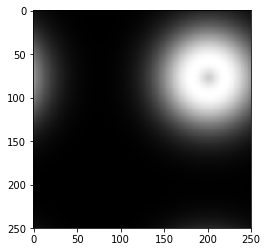

In [23]:
plt.imshow(images[3000], cmap='gray')

In [24]:
# compute the gif
imageio.mimsave('images.gif', images)

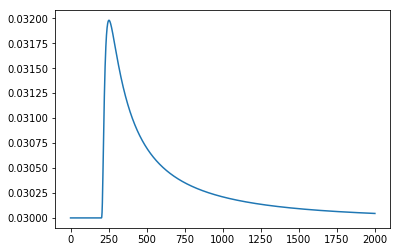

In [25]:
plt.plot(point_value[:2000,1])